In [2]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full.bin"

In [63]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [3]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

## No clean

In [4]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2.csv')

In [5]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [6]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [68]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3501
3501
3501


In [69]:
print(max(map(lambda x: len(x), sentences)))

84


In [10]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [8]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        seq_lengths = np.sum(np.array(x_train) !=0, axis=1)

        x_emb_pack = torch.nn.utils.rnn.pack_padded_sequence(x_emb,seq_lengths, batch_first=True, enforce_sorted=False)

        output , (h_n, _) = self.lstm(x_emb_pack.float())
        
        out = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=85)  

        out = out[0] 

        #print(out.shape)
        #output, (h_n, _) = self.lstm(x_emb.float())

        out = self.dense(out)

        out = torch.nn.functional.log_softmax(out)

        return out

In [11]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [12]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [19]:
print(model)

Model(
  (gen_embedding): Embedding(6620, 300)
  (lstm): LSTM(300, 150, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=300, out_features=3, bias=True)
)


In [74]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.60it/s]



epoch 0
	train_loss:1.081 valid_loss:1.063
	train_acc:44.87% valid_acc:51.35%
	train_f1:0.473 valid_f1:0.508
	train_confusion_matrix:
[[ 194  679  414]
 [ 566 2083  900]
 [ 251  824  681]]
	valid_confusion_matrix:
[[ 39 198 117]
 [ 49 641 217]
 [ 40 247 236]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]



epoch 1
	train_loss:1.039 valid_loss:1.033
	train_acc:54.29% valid_acc:53.59%
	train_f1:0.532 valid_f1:0.522
	train_confusion_matrix:
[[ 103  732  437]
 [ 194 2630  739]
 [  76  839  851]]
	valid_confusion_matrix:
[[ 34 205 115]
 [ 33 679 195]
 [ 36 244 243]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.59it/s]



epoch 2
	train_loss:1.005 valid_loss:1.006
	train_acc:56.72% valid_acc:55.94%
	train_f1:0.551 valid_f1:0.541
	train_confusion_matrix:
[[ 115  727  435]
 [ 153 2719  664]
 [  62  809  901]]
	valid_confusion_matrix:
[[ 38 205 111]
 [ 26 701 180]
 [ 38 226 259]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



epoch 3
	train_loss:0.964 valid_loss:0.980
	train_acc:59.15% valid_acc:57.51%
	train_f1:0.571 valid_f1:0.553
	train_confusion_matrix:
[[ 117  734  420]
 [ 116 2871  581]
 [  55  786  910]]
	valid_confusion_matrix:
[[ 39 207 108]
 [ 24 721 162]
 [ 34 223 266]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



epoch 4
	train_loss:0.925 valid_loss:0.953
	train_acc:61.22% valid_acc:58.80%
	train_f1:0.590 valid_f1:0.563
	train_confusion_matrix:
[[ 148  734  406]
 [  93 2915  489]
 [  67  744  935]]
	valid_confusion_matrix:
[[ 38 202 114]
 [ 19 738 150]
 [ 40 210 273]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.31it/s]



epoch 5
	train_loss:0.863 valid_loss:0.929
	train_acc:64.20% valid_acc:59.59%
	train_f1:0.631 valid_f1:0.587
	train_confusion_matrix:
[[ 213  647  399]
 [ 107 3024  425]
 [  84  691  982]]
	valid_confusion_matrix:
[[ 56 190 108]
 [ 22 746 139]
 [ 43 219 261]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



epoch 6
	train_loss:0.825 valid_loss:0.891
	train_acc:66.22% valid_acc:61.49%
	train_f1:0.662 valid_f1:0.616
	train_confusion_matrix:
[[ 291  573  405]
 [ 138 3076  353]
 [ 119  633  987]]
	valid_confusion_matrix:
[[ 77 177 100]
 [ 25 753 129]
 [ 53 203 267]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]



epoch 7
	train_loss:0.795 valid_loss:0.877
	train_acc:67.52% valid_acc:62.50%
	train_f1:0.675 valid_f1:0.630
	train_confusion_matrix:
[[ 331  570  385]
 [ 132 3112  313]
 [ 125  622 1020]]
	valid_confusion_matrix:
[[ 88 166 100]
 [ 33 755 119]
 [ 62 189 272]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.55it/s]



epoch 8
	train_loss:0.762 valid_loss:0.841
	train_acc:68.88% valid_acc:64.18%
	train_f1:0.692 valid_f1:0.640
	train_confusion_matrix:
[[ 368  528  380]
 [ 145 3107  323]
 [ 167  513 1076]]
	valid_confusion_matrix:
[[ 87 165 102]
 [ 37 770 100]
 [ 59 176 288]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



epoch 9
	train_loss:0.731 valid_loss:0.830
	train_acc:70.03% valid_acc:64.91%
	train_f1:0.704 valid_f1:0.650
	train_confusion_matrix:
[[ 400  495  378]
 [ 152 3086  313]
 [ 186  451 1129]]
	valid_confusion_matrix:
[[ 93 164  97]
 [ 35 784  88]
 [ 61 181 281]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.90it/s]



epoch 10
	train_loss:0.707 valid_loss:0.817
	train_acc:70.98% valid_acc:65.13%
	train_f1:0.715 valid_f1:0.658
	train_confusion_matrix:
[[ 426  462  365]
 [ 182 3090  285]
 [ 207  412 1163]]
	valid_confusion_matrix:
[[103 154  97]
 [ 39 775  93]
 [ 67 172 284]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.62it/s]



epoch 11
	train_loss:0.685 valid_loss:0.797
	train_acc:71.85% valid_acc:66.03%
	train_f1:0.722 valid_f1:0.665
	train_confusion_matrix:
[[ 453  477  350]
 [ 166 3125  246]
 [ 204  409 1149]]
	valid_confusion_matrix:
[[106 149  99]
 [ 42 773  92]
 [ 68 156 299]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.92it/s]



epoch 12
	train_loss:0.663 valid_loss:0.784
	train_acc:73.17% valid_acc:65.75%
	train_f1:0.740 valid_f1:0.662
	train_confusion_matrix:
[[ 509  439  341]
 [ 163 3163  236]
 [ 222  373 1166]]
	valid_confusion_matrix:
[[107 148  99]
 [ 53 763  91]
 [ 79 141 303]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



epoch 13
	train_loss:0.644 valid_loss:0.799
	train_acc:73.67% valid_acc:66.54%
	train_f1:0.745 valid_f1:0.673
	train_confusion_matrix:
[[ 540  428  324]
 [ 174 3125  240]
 [ 227  339 1182]]
	valid_confusion_matrix:
[[115 152  87]
 [ 42 781  84]
 [ 74 158 291]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



epoch 14
	train_loss:0.632 valid_loss:0.783
	train_acc:74.39% valid_acc:66.70%
	train_f1:0.758 valid_f1:0.676
	train_confusion_matrix:
[[ 566  401  303]
 [ 159 3175  233]
 [ 255  343 1179]]
	valid_confusion_matrix:
[[120 140  94]
 [ 50 769  88]
 [ 79 143 301]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.73it/s]



epoch 15
	train_loss:0.616 valid_loss:0.780
	train_acc:74.87% valid_acc:67.04%
	train_f1:0.759 valid_f1:0.680
	train_confusion_matrix:
[[ 565  403  302]
 [ 168 3150  248]
 [ 223  310 1214]]
	valid_confusion_matrix:
[[122 139  93]
 [ 46 772  89]
 [ 76 145 302]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



epoch 16
	train_loss:0.594 valid_loss:0.773
	train_acc:76.14% valid_acc:67.54%
	train_f1:0.772 valid_f1:0.682
	train_confusion_matrix:
[[ 593  386  265]
 [ 171 3189  206]
 [ 239  303 1229]]
	valid_confusion_matrix:
[[122 135  97]
 [ 50 767  90]
 [ 68 139 316]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



epoch 17
	train_loss:0.590 valid_loss:0.786
	train_acc:76.23% valid_acc:67.15%
	train_f1:0.775 valid_f1:0.683
	train_confusion_matrix:
[[ 616  357  319]
 [ 161 3193  227]
 [ 223  286 1235]]
	valid_confusion_matrix:
[[121 140  93]
 [ 40 785  82]
 [ 75 156 292]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.31it/s]



epoch 18
	train_loss:0.574 valid_loss:0.779
	train_acc:76.88% valid_acc:67.43%
	train_f1:0.783 valid_f1:0.691
	train_confusion_matrix:
[[ 632  362  294]
 [ 142 3241  213]
 [ 230  289 1216]]
	valid_confusion_matrix:
[[142 133  79]
 [ 62 771  74]
 [ 90 143 290]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


epoch 19
	train_loss:0.555 valid_loss:0.783
	train_acc:77.70% valid_acc:67.77%
	train_f1:0.790 valid_f1:0.686
	train_confusion_matrix:
[[ 649  335  266]
 [ 159 3207  199]
 [ 231  283 1277]]
	valid_confusion_matrix:
[[129 129  96]
 [ 53 759  95]
 [ 65 137 321]]


(0.3, 1.0)

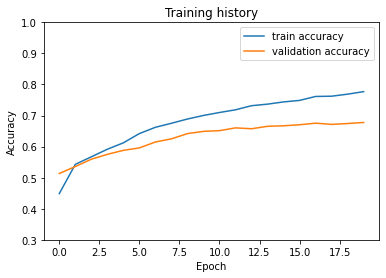

In [75]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [76]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full.bin


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2928943613.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

              precision    recall  f1-score   support

     Neutral       0.51      0.34      0.41       354
    Positive       0.74      0.85      0.79       907
    Negative       0.63      0.60      0.62       523

    accuracy                           0.68      1784
   macro avg       0.62      0.60      0.60      1784
weighted avg       0.66      0.68      0.66      1784



In [77]:
MODEL_PATH

'model_task2_full.bin'

---

In [78]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full_clean.bin"

In [79]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2_cleaned.csv')

In [80]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [81]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [82]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3501
3501
3501


In [83]:
print(max(map(lambda x: len(x), sentences)))

80


In [84]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [85]:
'''
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out
'''

'\nclass Model(torch.nn.Module):\n    def __init__(self, gen_emb, num_classes=3):\n        super(Model, self).__init__()\n        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])\n        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)\n        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)\n        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)\n\n    def forward(self, x_train):\n        x_emb = self.gen_embedding(x_train)\n\n        output, (h_n, _) = self.lstm(x_emb.float())\n        out = self.dense(output)\n\n        return out\n'

In [86]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        seq_lengths = np.sum(np.array(x_train) !=0, axis=1)

        x_emb_pack = torch.nn.utils.rnn.pack_padded_sequence(x_emb,seq_lengths, batch_first=True, enforce_sorted=False)

        output , (h_n, _) = self.lstm(x_emb_pack.float())
        
        out = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=85)  

        out = out[0] 

        out = self.dense(out)

        out = torch.nn.functional.log_softmax(out)


        return out

In [87]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [88]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [89]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.36it/s]



epoch 0
	train_loss:1.074 valid_loss:1.050
	train_acc:50.42% valid_acc:55.66%
	train_f1:0.531 valid_f1:0.541
	train_confusion_matrix:
[[ 164  813  224]
 [ 409 2636  394]
 [ 262 1092  448]]
	valid_confusion_matrix:
[[ 37 239 118]
 [ 63 790  94]
 [ 35 254 181]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.15it/s]



epoch 1
	train_loss:1.037 valid_loss:1.015
	train_acc:56.57% valid_acc:56.10%
	train_f1:0.552 valid_f1:0.538
	train_confusion_matrix:
[[ 108  773  330]
 [ 188 2763  503]
 [ 100  922  797]]
	valid_confusion_matrix:
[[ 26 210 158]
 [ 38 776 133]
 [ 22 234 214]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.04it/s]



epoch 2
	train_loss:1.000 valid_loss:0.982
	train_acc:58.50% valid_acc:56.82%
	train_f1:0.557 valid_f1:0.538
	train_confusion_matrix:
[[  74  725  406]
 [ 109 2789  564]
 [  59  821  921]]
	valid_confusion_matrix:
[[ 23 202 169]
 [ 27 773 147]
 [ 12 225 233]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.84it/s]



epoch 3
	train_loss:0.962 valid_loss:0.944
	train_acc:60.18% valid_acc:58.26%
	train_f1:0.568 valid_f1:0.553
	train_confusion_matrix:
[[  70  699  422]
 [  83 2834  551]
 [  35  784  986]]
	valid_confusion_matrix:
[[ 28 202 164]
 [ 24 789 134]
 [ 15 217 238]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.98it/s]



epoch 4
	train_loss:0.926 valid_loss:0.902
	train_acc:60.96% valid_acc:60.96%
	train_f1:0.573 valid_f1:0.583
	train_confusion_matrix:
[[  82  712  421]
 [  71 2848  504]
 [  39  773 1005]]
	valid_confusion_matrix:
[[ 40 200 154]
 [ 18 819 110]
 [ 26 199 245]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.76it/s]



epoch 5
	train_loss:0.887 valid_loss:0.865
	train_acc:62.44% valid_acc:62.84%
	train_f1:0.598 valid_f1:0.610
	train_confusion_matrix:
[[ 128  673  417]
 [  67 2901  461]
 [  52  754 1000]]
	valid_confusion_matrix:
[[ 56 194 144]
 [ 19 839  89]
 [ 29 198 243]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]



epoch 6
	train_loss:0.849 valid_loss:0.831
	train_acc:64.09% valid_acc:64.66%
	train_f1:0.617 valid_f1:0.632
	train_confusion_matrix:
[[ 155  670  389]
 [  90 2981  359]
 [  72  731  989]]
	valid_confusion_matrix:
[[ 68 185 141]
 [ 21 850  76]
 [ 34 183 253]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 7
	train_loss:0.813 valid_loss:0.807
	train_acc:66.15% valid_acc:64.61%
	train_f1:0.639 valid_f1:0.634
	train_confusion_matrix:
[[ 179  608  409]
 [ 111 3018  336]
 [  74  643 1066]]
	valid_confusion_matrix:
[[ 75 183 136]
 [ 20 829  98]
 [ 34 170 266]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]



epoch 8
	train_loss:0.790 valid_loss:0.780
	train_acc:67.15% valid_acc:65.71%
	train_f1:0.645 valid_f1:0.647
	train_confusion_matrix:
[[ 203  606  424]
 [ 109 3000  322]
 [  88  578 1145]]
	valid_confusion_matrix:
[[ 81 168 145]
 [ 23 830  94]
 [ 36 155 279]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.29it/s]



epoch 9
	train_loss:0.764 valid_loss:0.761
	train_acc:68.10% valid_acc:66.54%
	train_f1:0.659 valid_f1:0.652
	train_confusion_matrix:
[[ 215  548  442]
 [  97 2968  356]
 [ 103  511 1208]]
	valid_confusion_matrix:
[[ 81 174 139]
 [ 23 845  79]
 [ 42 149 279]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.88it/s]



epoch 10
	train_loss:0.737 valid_loss:0.744
	train_acc:69.63% valid_acc:67.26%
	train_f1:0.675 valid_f1:0.668
	train_confusion_matrix:
[[ 250  572  390]
 [  96 3049  302]
 [ 110  489 1192]]
	valid_confusion_matrix:
[[ 99 157 138]
 [ 29 822  96]
 [ 48 125 297]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.43it/s]



epoch 11
	train_loss:0.724 valid_loss:0.730
	train_acc:69.95% valid_acc:68.75%
	train_f1:0.686 valid_f1:0.691
	train_confusion_matrix:
[[ 287  524  408]
 [  90 3023  330]
 [ 118  469 1204]]
	valid_confusion_matrix:
[[116 138 140]
 [ 33 824  90]
 [ 57 108 305]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.42it/s]



epoch 12
	train_loss:0.702 valid_loss:0.719
	train_acc:70.68% valid_acc:68.53%
	train_f1:0.701 valid_f1:0.681
	train_confusion_matrix:
[[ 333  486  398]
 [ 128 3034  269]
 [ 165  441 1182]]
	valid_confusion_matrix:
[[104 154 136]
 [ 30 838  79]
 [ 59 112 299]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.86it/s]



epoch 13
	train_loss:0.680 valid_loss:0.713
	train_acc:72.50% valid_acc:68.75%
	train_f1:0.718 valid_f1:0.686
	train_confusion_matrix:
[[ 374  462  379]
 [ 130 3045  266]
 [ 134  401 1252]]
	valid_confusion_matrix:
[[112 154 128]
 [ 33 833  81]
 [ 65 105 300]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.20it/s]



epoch 14
	train_loss:0.671 valid_loss:0.704
	train_acc:73.04% valid_acc:68.64%
	train_f1:0.729 valid_f1:0.688
	train_confusion_matrix:
[[ 407  439  355]
 [ 134 3061  266]
 [ 153  393 1245]]
	valid_confusion_matrix:
[[116 149 129]
 [ 39 832  76]
 [ 73 102 295]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.49it/s]



epoch 15
	train_loss:0.644 valid_loss:0.692
	train_acc:74.23% valid_acc:69.85%
	train_f1:0.742 valid_f1:0.709
	train_confusion_matrix:
[[ 433  420  338]
 [ 140 3086  248]
 [ 161  352 1259]]
	valid_confusion_matrix:
[[142 134 118]
 [ 43 825  79]
 [ 75  97 298]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.21it/s]



epoch 16
	train_loss:0.634 valid_loss:0.688
	train_acc:74.85% valid_acc:70.35%
	train_f1:0.750 valid_f1:0.715
	train_confusion_matrix:
[[ 475  391  342]
 [ 141 3067  240]
 [ 163  353 1309]]
	valid_confusion_matrix:
[[149 137 108]
 [ 40 829  78]
 [ 77  97 296]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.34it/s]



epoch 17
	train_loss:0.622 valid_loss:0.686
	train_acc:75.32% valid_acc:70.96%
	train_f1:0.760 valid_f1:0.727
	train_confusion_matrix:
[[ 529  366  320]
 [ 148 3055  233]
 [ 182  340 1265]]
	valid_confusion_matrix:
[[164 110 120]
 [ 50 810  87]
 [ 74  85 311]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.65it/s]



epoch 18
	train_loss:0.606 valid_loss:0.684
	train_acc:76.41% valid_acc:70.62%
	train_f1:0.768 valid_f1:0.733
	train_confusion_matrix:
[[ 534  364  324]
 [ 138 3095  227]
 [ 151  323 1317]]
	valid_confusion_matrix:
[[182 100 112]
 [ 54 801  92]
 [ 83  91 296]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


epoch 19
	train_loss:0.590 valid_loss:0.681
	train_acc:76.69% valid_acc:71.29%
	train_f1:0.775 valid_f1:0.727
	train_confusion_matrix:
[[ 562  336  296]
 [ 163 3089  215]
 [ 183  315 1309]]
	valid_confusion_matrix:
[[159 124 111]
 [ 38 826  83]
 [ 70  94 306]]


(0.3, 1.0)

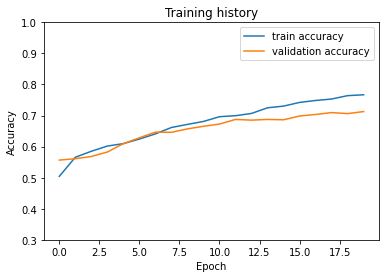

In [90]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [91]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full_clean.bin


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_14909/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

              precision    recall  f1-score   support

     Neutral       0.60      0.40      0.48       394
    Positive       0.79      0.87      0.83       947
    Negative       0.61      0.65      0.63       470

    accuracy                           0.71      1811
   macro avg       0.67      0.64      0.65      1811
weighted avg       0.70      0.71      0.70      1811



In [92]:
MODEL_PATH

'model_task2_full_clean.bin'